<a href="https://colab.research.google.com/github/sd3ntato/ISPR_Project/blob/main/btc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project consists in using DeepESN and (possibly)GruESN to predict bitcoin stock market price.

I use a dataset from kaggle that reports price minute by minute.

#preliminary stuff 

In [ ]:
# reference to dataset:
# https://www.kaggle.com/mczielinski/bitcoin-historical-data

# mainstream libraries
import numpy as np
import pandas as pd
import math
import plotly.graph_objects as go
from IPython.display import clear_output


# i need code and data from my drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# import code for ESN, DeepESN, GruESN from drive
import sys
sys.path.append('/content/drive/Othercomputers/Il mio MacBook Air/SimpleESN')
sys.path.append('/content/drive/Othercomputers/Il mio MacBook Air/ISPR_Project')
from Simple_ESN import ESN, MSE
from functions import *

n_trials = 50

Mounted at /content/drive


##lettura and visualization

In [ ]:
# read the dataset with data minute by minute.
data = pd.read_csv("/content/drive/MyDrive/ISPR/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
data = data.dropna(how='any') # na slots are when price does not change.
data.index = pd.RangeIndex(len(data.index))

from datetime import datetime
timestamps = data['Timestamp'].to_numpy().tolist()
dates = list([datetime.fromtimestamp( t ) for t in timestamps])
data['Dates'] = dates

print(f'total number of samples given: {len(data)}')

# we take for example the last 10 000 (approximately 10 weeks) and the same amount for testing
data = data[-13000:]
data

total number of samples given: 3613769


Timestamp      Open  ...  Weighted_Price               Dates
3600769  1616366520  57747.16  ...    57759.129449 2021-03-21 22:42:00
3600770  1616366580  57776.54  ...    57736.569842 2021-03-21 22:43:00
3600771  1616366640  57764.47  ...    57774.318362 2021-03-21 22:44:00
3600772  1616366700  57748.37  ...    57760.980994 2021-03-21 22:45:00
3600773  1616366760  57792.07  ...    57800.905108 2021-03-21 22:46:00
...             ...       ...  ...             ...                 ...
3613764  1617148560  58714.31  ...    58692.753339 2021-03-30 23:56:00
3613765  1617148620  58683.97  ...    58693.226508 2021-03-30 23:57:00
3613766  1617148680  58693.43  ...    58696.198496 2021-03-30 23:58:00
3613767  1617148740  58742.18  ...    58761.866202 2021-03-30 23:59:00
3613768  1617148800  58767.75  ...    58764.349363 2021-03-31 00:00:00

[13000 rows x 9 columns]

In [ ]:
# visualize and work on some of the data:
fig = go.Figure(data=[go.Candlestick(x=data['Dates'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])

fig.show()

##Preprocessing
shift the data separating input from target output, than separate training, validation and test data.

In [ ]:
# temporal shift: we try and predict the price r minutes ahead.
r = 3

# put data inside a matrix, only ohlc values
dataset_x = data[['Open','High','Low','Close']].to_numpy()

# normalize data to 0 mean and 1 variance
dataset_x = normalize(dataset_x)

# separate input data from output data: output data is shifted to the left by r positions,
# so that it goes ahead by r temporal steps w.r.t. dataset_x . 
dataset_y = np.roll(dataset_x,-r,axis=0)

# discard rolled positions because they are not meaningfull anymore
dataset_x = dataset_x[r:np.size(dataset_x)-r]
dataset_y = dataset_y[r:np.size(dataset_y)-r]

# y[t] = x[t+r]  
# y[t] is r steps in the future w.r.t. x[t]
for t in range(np.size(dataset_x,axis=0)-r):
  assert np.linalg.norm(dataset_x[t+r] - dataset_y[t])==0.0

# separate training data from validation and test.
train_x = dataset_x[:4000]
train_y = dataset_y[:4000]

valid_x = dataset_x[4000:5000]
valid_y = dataset_y[4000:5000]


test_x = dataset_x[5000:]
test_y = dataset_y[5000:]

print(f'\nDATA SHAPES \ntraining data: {np.shape(train_x)},{np.shape(train_y)},\nvalid data: {np.shape(valid_x)},{np.shape(valid_y)}, \ntest data: {np.shape(test_x)}, {np.shape(test_y)}')


DATA SHAPES 
training data: (4000, 4),(4000, 4),
valid data: (1000, 4),(1000, 4), 
test data: (7997, 4), (7997, 4)


# LOCAL IMPLEMENTATIONS

In [ ]:
# When working with my implementation of ESN, the convention is that every data point is a column vector
# reshape data so that each data point is a column vector, we have a tensor containing datapoints in the form of column vector
train_x = train_x.reshape(-1,4,1)
train_y = train_y.reshape(-1,4,1)
valid_x = valid_x.reshape(-1,4,1)
valid_y = valid_y.reshape(-1,4,1)
test_x = test_x.reshape(-1,4,1)
test_y = test_y.reshape(-1,4,1)

## ESN shallow

In [ ]:
# now that we got the data ready, we can go ahead and train a network on it, then asses the results. 
# We start with an initial very simple trial using a shallow ESN, just to see if the framework is working.
n = ESN(Nu=4, Ny=4,rho=1, Nr=100, r_density =0.1, i_density =1)
n.train(train_x[501:],train_y[501:],train_x[:500])
err , out = n.score(test_x,test_y)
print(f'MSE on test dataset: {err}')

MSE on test dataset: 0.0017660058057181313


In [ ]:
# we arrange the obtained data in dataframes so that we can pretty-plot them
real = ohlc_matrix_to_dataframe(test_y.reshape(-1,4)) 
predicted = ohlc_matrix_to_dataframe(out.reshape(-1,4),r=r)

# then actually plot the results:
# we plot candlestick graph with a bar indicating the predicted Low value.

fig = plot_comparison_candlesticks_with_predicted_low(real, predicted)
fig.show()

In [ ]:
errs_ESN = [None]*n_trials
for i in range(n_trials):
  n = ESN(Nu=4, Ny=4,rho=1, Nr=100, r_density =0.1, i_density =1)
  n.train(train_x[501:],train_y[501:],train_x[:500])
  err , _ = n.score(test_x,test_y)
  errs_ESN[i] = err
errs_ESN

## DeepESN readout concat

In [ ]:
from SimpleDeepESN import DeepESN
n = DeepESN(Nu=4, Ny=4,N=4,Nr=10,rho=0.3)
n.train_concat(train_x[501:],train_y[501:],train_x[:500])
err , out = n.score_concat(test_x,test_y)
print(f'MSE on test dataset: {err}')

MSE on test dataset: 0.0016724875943216948


In [ ]:
# we arrange the obtained data in dataframes so that we can pretty-plot them
real = ohlc_matrix_to_dataframe(test_y.reshape(-1,4)) 
predicted = ohlc_matrix_to_dataframe(out.reshape(-1,4),r=r)

# then actually plot the results:
# we plot candlestick graph with a bar indicating the predicted Low value.

fig = plot_comparison_candlesticks_with_predicted_low(real, predicted)
fig.show()

In [ ]:
errs_DeepESN_concat = [None]*n_trials
for i in range(n_trials):
  n = DeepESN(Nu=4, Ny=4,N=4,Nr=10,rho=0.3)
  n.train_concat(train_x[501:],train_y[501:],train_x[:500])
  err , out = n.score_concat(test_x,test_y)
  errs_DeepESN_concat[i] = err
errs_DeepESN_concat

##DeepESN readout ultimo layer

In [ ]:
from SimpleDeepESN import DeepESN
Nl=3
n = DeepESN(Nu=4, Ny=4,N=4,Nr=30, rho=0.2)
n.train(train_x[501:],train_y[501:],train_x[:500],Nl-1)
err , out = n.score(test_x,test_y,Nl-1)
print(f'MSE on test dataset: {err}')

MSE on test dataset: 0.0017561638675538814


In [ ]:
# we arrange the obtained data in dataframes so that we can pretty-plot them
real = ohlc_matrix_to_dataframe(test_y.reshape(-1,4)) 
predicted = ohlc_matrix_to_dataframe(out.reshape(-1,4),r=r)

# then actually plot the results:
# we plot candlestick graph with a bar indicating the predicted Low value.

fig = plot_comparison_candlesticks_with_predicted_low(real, predicted)
fig.show()

In [ ]:
errs_DeepESN_last = [None]*n_trials
for i in range(n_trials):
  Nl=3
  n = DeepESN(Nu=4, Ny=4,N=Nl,Nr=30, rho=0.2)
  n.train(train_x[501:],train_y[501:],train_x[:500],Nl-1)
  err , out = n.score(test_x,test_y,Nl-1)
  errs_DeepESN_last[i] = err
errs_DeepESN_last

# KERAS

In [ ]:
tx = train_x.reshape(-1,100,4)
ty = train_y.reshape(-1,100,4)

vx = valid_x.reshape(1,-1,4)
vy = valid_y.reshape(1,-1,4)

ttx = test_x.reshape(1,-1,4)
tty = test_y.reshape(1,-1,4)

## GruESN

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from scipy.stats import uniform
import scipy.sparse as s

class Recurrent_sparse_initializer(tf.keras.initializers.Initializer):

    def __call__(self, shape, dtype=None):
      wrandom = s.random(shape[0],shape[1],density = 0.1, data_rvs=uniform(loc=-1,scale=2).rvs ).todense() # matrice sparsa con valori in distribuzione uniforme tra -1 e 1
      w = wrandom * ( 0.9 / max(np.abs(np.linalg.eigvals(wrandom))) )
      return np.array(w)


class GruESNRZCell(keras.layers.Layer):
  def __init__(self, units, **kwargs):

    self.state_size = units
    super().__init__(**kwargs)

  def build(self, input_shape):
    
    self.Wrin = self.add_weight( shape=(input_shape[-1], self.state_size), initializer="uniform", trainable =True)

    self.Wr = self.add_weight(shape=(self.state_size, self.state_size), initializer="uniform", trainable =True)

    self.Wzin = self.add_weight(shape=(input_shape[-1], self.state_size), initializer="uniform", trainable =True)

    self.Wz = self.add_weight(shape=(self.state_size, self.state_size), initializer="uniform", trainable =True)

    self.Win = self.add_weight(shape=(input_shape[-1], self.state_size), initializer="uniform", trainable =False)

    self.W = self.add_weight(shape=(self.state_size, self.state_size), initializer=Recurrent_sparse_initializer(), trainable =False)

    self.built = True
    
  def call(self, inputs, states):

    u = inputs
    x_tm1 = states[0]

    r = tf.math.sigmoid( tf.matmul(inputs, self.Wrin ) + tf.matmul( x_tm1, self.Wr) )
    z = tf.math.sigmoid( tf.matmul(inputs, self.Wzin ) + tf.matmul( x_tm1, self.Wz) )
    h = tf.math.tanh( tf.matmul(inputs, self.Win) + tf.matmul( tf.math.multiply(r, x_tm1), self.W ) )
    x = tf.math.multiply( z, x_tm1) + tf.math.multiply( (tf.ones(self.state_size) - z), h  )

    return x, [x]


In [ ]:
model = keras.models.Sequential([
      #keras.layers.GRU(100, stateful=True, return_sequences=True, batch_input_shape=(1, 10000, 4)), # stateful one
      #keras.layers.RNN( GruESNRZCell(100),return_sequences=True, input_shape=(None, 4)),
      keras.layers.GRU( 100,return_sequences=True, input_shape=(None, 4)),
      #keras.layers.Dense(10),  
      keras.layers.Dense(4), 
])
model.compile(optimizer="adam", loss="mse", sample_weight_mode="temporal",)
print(model.summary())
model.fit(tx,ty,epochs=20, batch_size=1, shuffle=True)
clear_output()

out = model.predict(ttx)

# we arrange the obtained data in dataframes so that we can pretty-plot them
real = ohlc_matrix_to_dataframe(test_y.reshape(-1,4)) 
predicted = ohlc_matrix_to_dataframe(out.reshape(-1,4),r=r)

# then actually plot the results:
# we plot candlestick graph with a bar indicating the predicted Low value.

fig = plot_comparison_candlesticks_with_predicted_low(real, predicted)
fig.show()

err = MSE( out.reshape(-1,4), tty.reshape(-1,4), 500)
print(f'MSE on test dataset: {err}')

MSE on test dataset: 0.0028674878392627077


In [ ]:
errs_GruESN = [None]*n_trials
for i in range(n_trials):
  model = keras.models.Sequential([
      keras.layers.RNN( GruESNRZCell(100),return_sequences=True, input_shape=(None, 4)),
      keras.layers.Dense(4), 
  ])
  model.compile(optimizer="rmsprop", loss="mse", sample_weight_mode="temporal",)
  model.fit(tx,ty,epochs=15, batch_size=1, shuffle=True,verbose=False)
  out = model.predict(ttx)
  err = MSE( out.reshape(-1,4), tty.reshape(-1,4), 500)
  print(f'MSE on test dataset: {err}')
  clear_output(wait=True)
  errs_GruESN[i] = err
errs_GruESN

In [ ]:
errs_Gru = [None]*n_trials
for i in range(n_trials):
  model = keras.models.Sequential([
      keras.layers.GRU( 100, return_sequences=True, input_shape=(None, 4)),
      keras.layers.Dense(4), 
  ])
  model.compile(optimizer="adam", loss="mse", sample_weight_mode="temporal",)
  model.fit(tx,ty,epochs=20, batch_size=1, shuffle=True)
  out = model.predict(ttx)
  err = MSE( out.reshape(-1,4), tty.reshape(-1,4), 500)
  print(f'MSE on test dataset: {err}')
  clear_output(wait=True)
  errs_Gru[i] = err
errs_Gru

#tabular data

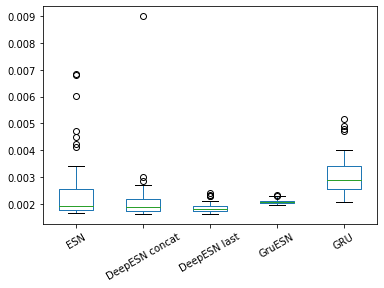

In [65]:
errs = {
    'ESN':errs_ESN,
    'DeepESN concat':errs_DeepESN_concat,
    'DeepESN last':errs_DeepESN_last,
    'GruESN': errs_GruESN,
    'GRU': errs_Gru
}
errs = pd.DataFrame(errs)
errs.plot(kind='box', rot='30')

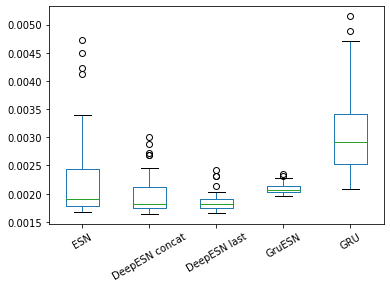

In [ ]:
e1 = errs.drop(errs['DeepESN concat'].idxmax()).drop(errs['ESN'].idxmax())
e1 = e1.drop(e1['ESN'].idxmax())
e1 = e1.drop(e1['ESN'].idxmax())
e1.plot(kind='box',rot=30)

In [70]:
errs.describe()

ESN  DeepESN concat  DeepESN last     GruESN        GRU
count  50.000000       50.000000     50.000000  50.000000  50.000000
mean    0.002527        0.002140      0.001865   0.002091   0.003092
std     0.001284        0.001048      0.000181   0.000096   0.000744
min     0.001675        0.001641      0.001638   0.001956   0.002084
25%     0.001796        0.001743      0.001747   0.002028   0.002548
50%     0.001938        0.001892      0.001827   0.002065   0.002908
75%     0.002572        0.002181      0.001933   0.002134   0.003411
max     0.006859        0.008989      0.002415   0.002355   0.005148

In [68]:
errs.to_numpy()

array([[0.00316918, 0.00898904, 0.00163808, 0.00204519, 0.0027513 ],
       [0.00191077, 0.00173392, 0.00183523, 0.00204289, 0.00324332],
       [0.00279298, 0.00190863, 0.00188993, 0.00235507, 0.00250903],
       [0.00184784, 0.0030103 , 0.0019523 , 0.00203457, 0.0033252 ],
       [0.00185479, 0.00180935, 0.00166794, 0.00212832, 0.00471017],
       [0.0068585 , 0.00220132, 0.00189411, 0.00203182, 0.00272451],
       [0.00201448, 0.00181146, 0.00180959, 0.00216897, 0.00239263],
       [0.00196509, 0.00167529, 0.00198286, 0.00216323, 0.00343367],
       [0.00678633, 0.00194072, 0.00232886, 0.00224828, 0.00480423],
       [0.00174891, 0.00176639, 0.00203516, 0.00196121, 0.00233907],
       [0.00473027, 0.00272453, 0.00190357, 0.00195994, 0.00271189],
       [0.00190327, 0.00211922, 0.00241508, 0.00208072, 0.00316191],
       [0.00340035, 0.00210478, 0.00168661, 0.00211668, 0.00263952],
       [0.00334362, 0.00191775, 0.00172235, 0.00198083, 0.00488901],
       [0.00183256, 0.00287869, 0.